In [4]:
# Dependencies
import numpy as np
from PIL import Image
import open3d as o3d
import json
import os
from tqdm import tqdm

from sklearn.cluster import DBSCAN

import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from matplotlib import rcParams

import os.path as osp
from nuscenes import NuScenes

# Utils for Lidar and Radar
from nuscenes.nuscenes import NuScenes
from utils.misc import *

%matplotlib inline

In [5]:
#nusc = NuScenes(version='v1.0-mini', dataroot='/home/gus/Documents/AI_S/nuScenes/v1_0-mini', verbose=True)
nusc = NuScenes(version='v1.0-mini', dataroot='/home/sherlock/Documents/nuScenes/data', verbose=True)

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.477 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


## Obtaining a simple annotation

In [6]:
# Load the information from .txt file in JSON format
sample_path = os.getcwd() + '/dataset/samples/sample_841dd6709e9b4d7c9d6bf888f1fe6d7e_file.txt'

# This is a Dictionary of lists of dictionaries
data_json = load_file(sample_path)

## Point cloud data and visualization

In [7]:
# Create instance metadata
annotation_metadata = data_json['instance'][1]

# point cloud
pointcloud_lidar = load_pcl_txt(annotation_metadata['pointcloud_path'], annotation_metadata['pcl_shape'])

# Plotting the segmented point cloud
Velopoints = np.asarray(pointcloud_lidar.T, np.float32)

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(Velopoints)

# visualizing the 3D point cloud
o3d.visualization.draw_geometries([pcd])

## Retrieving image

In [8]:
# Sample data from cam Sensor
cam_data = nusc.get('sample_data', annotation_metadata['camera_token'])
cam_data

{'token': '57bd2cd794b943e9acd06a9883ea937f',
 'sample_token': '841dd6709e9b4d7c9d6bf888f1fe6d7e',
 'ego_pose_token': '57bd2cd794b943e9acd06a9883ea937f',
 'calibrated_sensor_token': 'e42949afbacd46239ea8e5e0f9275d50',
 'timestamp': 1538984249927893,
 'fileformat': 'jpg',
 'is_key_frame': True,
 'height': 900,
 'width': 1600,
 'filename': 'samples/CAM_BACK_RIGHT/n015-2018-10-08-15-36-50+0800__CAM_BACK_RIGHT__1538984249927893.jpg',
 'prev': 'fa3e20749189464eb7d4574b85a487ec',
 'next': '196d488de415472ba2b79f9189c51023',
 'sensor_modality': 'camera',
 'channel': 'CAM_BACK_RIGHT'}

## Plotting the current image frame

(-0.5, 1599.5, 899.5, -0.5)

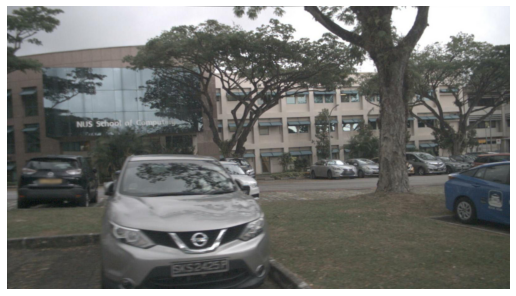

In [9]:
# Open image of the interest camera
im = Image.open(osp.join(nusc.dataroot, cam_data['filename']))

plt.figure(figsize=(9, 16))
plt.imshow(im)
plt.axis('off')

## Plotting the point cloud on the image

(-0.5, 1599.5, 899.5, -0.5)

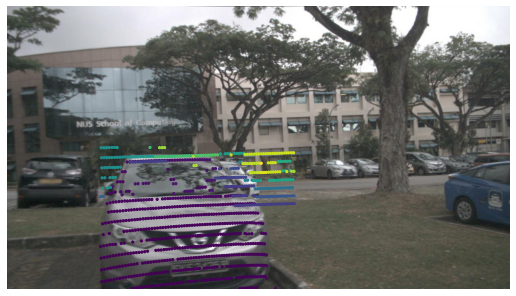

In [10]:
# point cloud
pointcloud_cam = load_pcl_txt(annotation_metadata['img_pc_path'], annotation_metadata['img_pcl_shape'])

plt.figure(figsize=(9, 16))
plt.imshow(im)
plt.scatter(pointcloud_cam[0, :], pointcloud_cam[1, :], c = pointcloud_cam[3, :], s = 5)
plt.axis('off')

# Test with different unsupervised learning methods for clustering

The following lines use different unsupervised learning algorithms to segment a given instance. This is just for the sake of testing.

### Instance segmentation K-means

In [67]:
from sklearn.cluster import KMeans

# Using the Kmeans object
clustering = KMeans(n_clusters = 5).fit(pointcloud_lidar.T)
# Clusters
kmeans_clusters = clustering.labels_
print('The unique clusters label are: {}'.format(np.unique(kmeans_clusters)))

The unique clusters label are: [0 1 2 3 4]


### Instance segmentation AgglomerativeClustering

In [9]:
from sklearn.cluster import AgglomerativeClustering

# Using the AgglomerativeClustering object
clustering = AgglomerativeClustering(n_clusters = 5).fit(pointcloud_lidar.T)
# Clusters
aglomerative_clusters = clustering.labels_
print('The unique clusters label are: {}'.format(np.unique(aglomerative_clusters)))

The unique clusters label are: [0 1 2 3 4]


### Instance segmentation MeanShift

In [10]:
from sklearn.cluster import MeanShift

# Using the MeanShift object
clustering = MeanShift(cluster_all = False).fit(pointcloud_lidar.T)
# Clusters
meanshift_clusters = clustering.labels_
print('The unique clusters label are: {}'.format(np.unique(meanshift_clusters)))

The unique clusters label are: [-1  0  1  2  3  4]


### Instance segmentation DBSCAN

In [11]:
# Using the DBScan object using Manhattan distance 'cityblock' 'euclidean' pointcloud_lidar.T
clustering = DBSCAN(eps = 1.5, min_samples = 20, metric = 'euclidean').fit(pointcloud_lidar.T)
# Clusters
dbscan_clusters = clustering.labels_ 
print('The unique clusters label are: {}'.format(np.unique(dbscan_clusters)))

The unique clusters label are: [-1  0  1  2  3  4]


### Instance segmentation HDBSCAN

In [113]:
import hdbscan

clusterer = hdbscan.HDBSCAN(min_cluster_size = 30).fit(pointcloud_lidar.T)
dbscan_clusters = clusterer.labels_
print('The unique clusters label are: {}'.format(np.unique(dbscan_clusters)))

The unique clusters label are: [-1  0  1]


## Find the cluster with the biggest amount of points

Test method to find the cluster with the biggest number of points within it. The algorithm used by default is DBSCAN.

In [114]:
# Number of unique clusters and Delete -1 (noisy) class
# options: kmeans_clusters - aglomerative_clusters - meanshift_clusters - dbscan_clusters

pcd_path =  os.getcwd() + '/dataset/pcd_segmentation/'

# Obtain the more repeated index different of -1
class_idx = np.bincount(dbscan_clusters[dbscan_clusters != -1]).argmax()
# Find indexes of interest cluster
indexes = np.where(dbscan_clusters == class_idx)[0]

# extract the point cloud of the current cluster
pcl_temp = pointcloud_lidar.T[indexes]
#  and save the point cloud in pcd
Velopoints = np.asarray(pcl_temp, np.float32)
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(Velopoints)

# Saves the point cloud in .pcd file
o3d.io.write_point_cloud(pcd_path + 'pcd_segmentation_' + annotation_metadata['annotation_token'] + '.pcd', pcd)

# visualizing the 3D point cloud
o3d.visualization.draw_geometries([pcd])

## Segment all point clouds (Frustums)

This for loop segments all the point clouds in the dataset. They will be stored in a new folder and will be used for feature extraction.

In [12]:
# path with all the sample files
samples_path =  os.getcwd() + '/dataset/samples/'

# path to save point clouds in .pcd
pcd_path =  os.getcwd() + '/dataset/pcd_segmentation/'

# extract all files in path
for root, dirs, files in os.walk(samples_path):
    
    # select each sample file
    for file_ in tqdm(files, desc = "Sample files"):    
        
        # load the current sample file
        data_json = load_file(samples_path + file_)
                
        # process each instance
        for index in range(len(data_json['instance'])):
            
            # Create instance metadata
            annotation_metadata = data_json['instance'][index]

            # point cloud
            pointcloud_lidar = load_pcl_txt(annotation_metadata['pointcloud_path'], annotation_metadata['pcl_shape'])
            
            #clustering = hdbscan.HDBSCAN(min_cluster_size = 20).fit(pointcloud_lidar.T)
            #dbscan_clusters = clustering.labels_
            
            clustering = DBSCAN(eps = 1.75, min_samples = 20).fit(pointcloud_lidar.T)
            # Clusters
            dbscan_clusters = clustering.labels_

            # There is only noise and no proper segmentation was obtained
            #if np.unique(dbscan_clusters).shape[0] == 1:
            #    continue
                
            # Obtain the more repeated index different of -1
            class_idx = np.bincount(dbscan_clusters[dbscan_clusters != -1]).argmax()
            # Find indexes of interest cluster
            indexes = np.where(dbscan_clusters == class_idx)[0]
            
            # extract the bigger cluster
            pcl_temp = pointcloud_lidar.T[indexes]

            Velopoints = np.asarray(pcl_temp, np.float32)
            
            #print(Velopoints.shape)
            
            pcd = o3d.geometry.PointCloud()
            pcd.points = o3d.utility.Vector3dVector(Velopoints)

            # Saves the point cloud in .pcd file
            o3d.io.write_point_cloud(pcd_path + 'pcd_segmentation_' + 
                                     annotation_metadata['annotation_token']+'.pcd', pcd)

            # visualizing the 3D point cloud
            #o3d.visualization.draw_geometries([pcd])

Sample files: 100%|██████████| 404/404 [00:14<00:00, 28.80it/s]


# Optional lines

The next cells are optional and are examples of instance segmentation using open3d, voxelization and local feature extraction out of a point cloud.

## Computing clusters with open3D

In [14]:
# Plotting the segmented point cloud
Velopoints = np.asarray(pointcloud_lidar.T, np.float32)

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(Velopoints)

with o3d.utility.VerbosityContextManager(o3d.utility.VerbosityLevel.Debug) as cm:
    labels = np.array(pcd.cluster_dbscan(eps=1.0, min_points=10, print_progress=True))

max_label = labels.max()
print(f"point cloud has {max_label + 1} clusters")
colors = plt.get_cmap("tab20")(labels / (max_label if max_label > 0 else 1))
colors[labels < 0] = 0
pcd.colors = o3d.utility.Vector3dVector(colors[:, :3])
o3d.visualization.draw_geometries([pcd])

[Open3D DEBUG] Precompute Neighbours
[Open3D DEBUG] Done Precompute Neighbours
[Open3D DEBUG] Compute Clusters
[Open3D DEBUG] Done Compute Clusters: 3
point cloud has 3 clusters


## Voxelization 

In [15]:
N = pcl_temp.shape[0]
print('Original number of points', N)
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(pcl_temp)

# fit to unit cube
pcd.scale(1 / np.max(pcd.get_max_bound() - pcd.get_min_bound()), center=pcd.get_center())
pcd.colors = o3d.utility.Vector3dVector(np.random.uniform(0,1,size=(N,3)))
o3d.visualization.draw_geometries([pcd])

print('voxelization')
voxel_grid = o3d.geometry.VoxelGrid.create_from_point_cloud(pcd, voxel_size=0.025)
o3d.visualization.draw_geometries([voxel_grid])
print(voxel_grid)

Original number of points 1167
voxelization
geometry::VoxelGrid with 367 voxels.


## Extracting geometric features FPFH

In [16]:
# Method taken from here
def preprocess_point_cloud(pcd, voxel_size):
    # Voxel downsampling
    # http://www.open3d.org/docs/release/tutorial/Basic/pointcloud.html#Voxel-downsampling
    print(":: Downsample with a voxel size %.3f." % voxel_size)
    pcd_down = pcd.voxel_down_sample(voxel_size)

    o3d.visualization.draw_geometries([pcd_down])
    
    # Computing normals
    # http://www.open3d.org/docs/release/tutorial/Basic/pointcloud.html
    radius_normal = voxel_size * 2
    print(":: Estimate normal with search radius %.3f." % radius_normal)
    pcd_down.estimate_normals(
        o3d.geometry.KDTreeSearchParamHybrid(radius=radius_normal, max_nn = 30))

    radius_feature = voxel_size * 5
    print(":: Compute FPFH feature with search radius %.3f." % radius_feature)
    pcd_fpfh = o3d.registration.compute_fpfh_feature(
        pcd_down,
        o3d.geometry.KDTreeSearchParamHybrid(radius = radius_feature, max_nn=100))
    return pcd_down, pcd_fpfh

In [17]:
# Creating Point Cloud object
Velopoints = np.asarray(pcl_temp, np.float32)
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(Velopoints)

# stablish voxel size for downsampling
voxel_size = 0.05 # means 5cm for this dataset

source_down, fpfh_vector = preprocess_point_cloud(pcd, voxel_size)
# This shit is always of dim = 33
fpfh_vector.data.shape

:: Downsample with a voxel size 0.050.
:: Estimate normal with search radius 0.100.
:: Compute FPFH feature with search radius 0.250.


(33, 1040)